In [1]:
import torch
import torch.nn as nn
import pandas
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from statistics import mean
import numpy as np
from tqdm.notebook import tqdm

In [2]:
torch.manual_seed(123)
torch.set_default_dtype(torch.double)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)
torch.cuda.empty_cache()


cuda


In [3]:
detection_train = torch.load("./data/detection_train.pt")
print(len(detection_train))
detection_test = torch.load("./data/detection_test.pt")
detection_val = torch.load("./data/detection_val.pt")

6886


In [4]:
def to_lower_xy(input, H, W):
    scale_w = 20
    scale_h = 24
    x = input[1] * scale_w
    y = input[2] * scale_h
    w = input[3] * scale_w
    h = input[4] * scale_h

    lower_x = x - w / 2
    lower_y = y - h / 2

    return lower_x + (scale_w * W), lower_y + (scale_h * H), w, h


def plot_data(data, title):

    COL = 5
    ROW = 2
    fig = plt.figure(figsize=(10, 4), dpi=500)

    for index in range(1, COL * ROW + 1):
        plt.subplot(ROW, COL, index)
        plt.axis("off")
        plt.imshow(data.tensors[0][index][0], cmap="gray_r")

        for h, list_y_true in enumerate(data.tensors[1][index]):
            for w, y_true in enumerate(list_y_true):
                if y_true[0] == 1:
                    draw_x, draw_y, draw_w, draw_h = to_lower_xy(y_true, h, w)
                    rect = Rectangle(
                        (draw_x, draw_y),
                        draw_w,
                        draw_h,
                        linewidth=1,
                        edgecolor="g",
                        facecolor="none",
                    )
                    ax = plt.gca()
                    ax.add_patch(rect)
                    t = plt.text(
                        draw_x, draw_y - 1, f"y_true:{int(y_true[5])}", fontsize=4
                    )
                    t.set_bbox(dict(facecolor="green", alpha=0.3, edgecolor="green"))

    fig.suptitle(title)


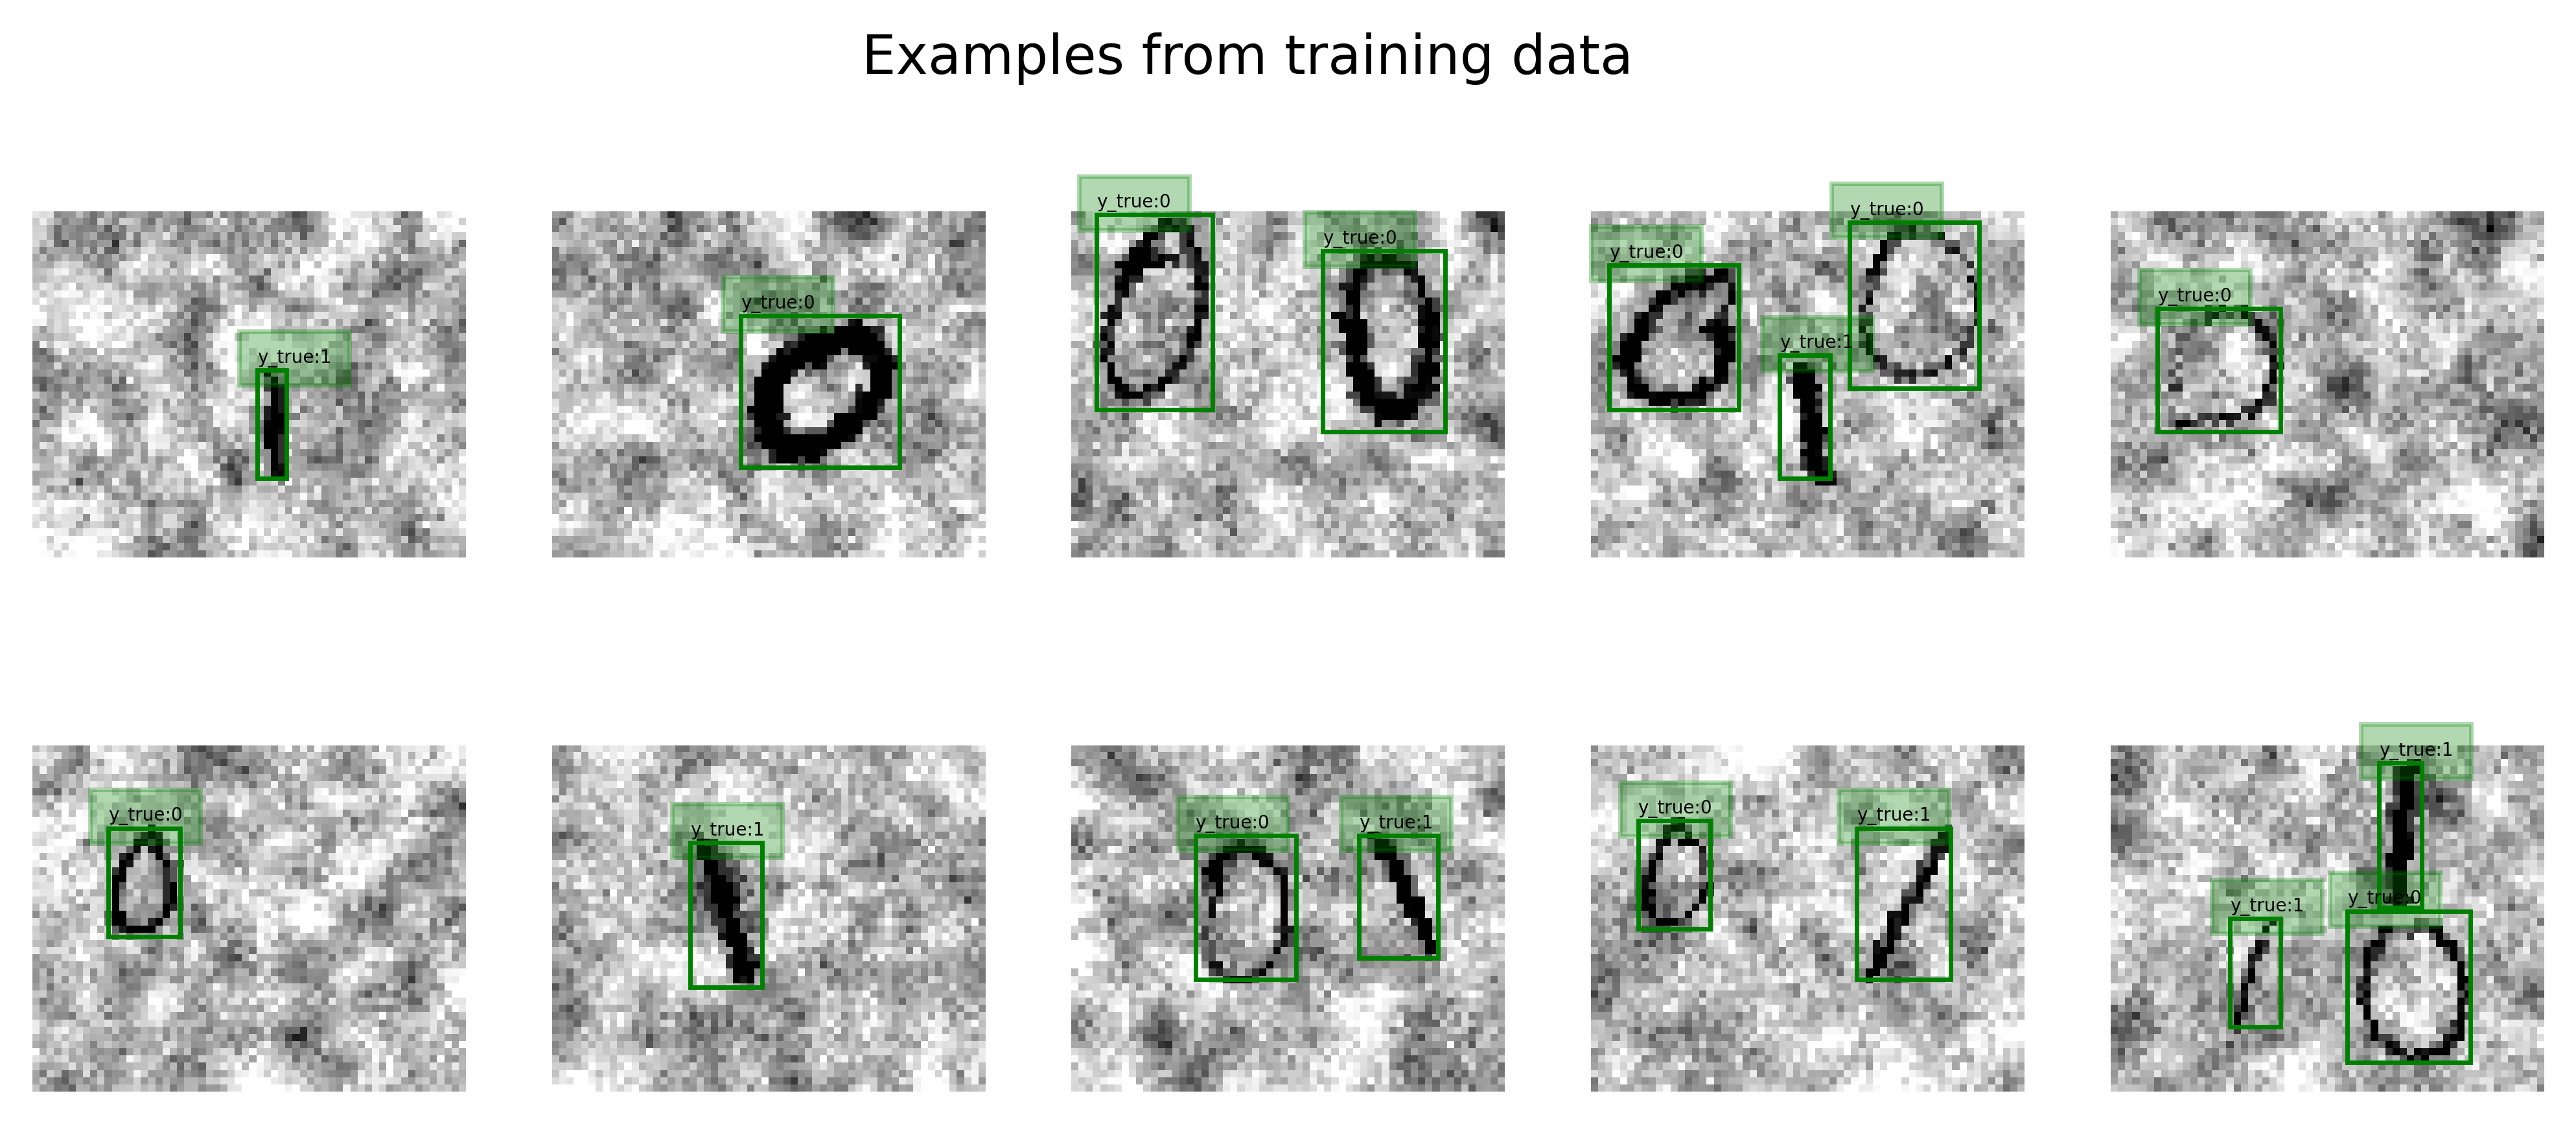

In [5]:
plot_data(detection_train, "Examples from training data")

tensor([[[1.0000, 0.5500, 0.5625, 0.8000, 1.1250, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [1.0000, 0.1411, 0.7292, 0.8500, 1.0417, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]]],
       dtype=torch.float32)
tensor(20., dtype=torch.float32) tensor(0., dtype=torch.float32) tensor(0., dtype=torch.float32) tensor(0., dtype=torch.float32)
tensor([0., 0., 0., 0., 0., 0.], dtype=torch.float32)
tensor(0., dtype=torch.float32) tensor(24., dtype=torch.float32) tensor(0., dtype=torch.float32) tensor(0., dtype=torch.float32)


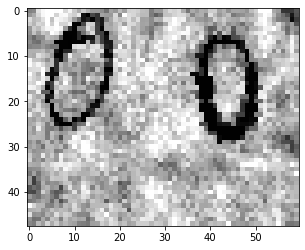

In [6]:
i = 3
print(detection_train.tensors[1][i])
plt.imshow(detection_train.tensors[0][i][0], cmap="gray_r")

x, y, w, h = to_lower_xy(detection_train.tensors[1][i][0][1], 0, 1)
print(x, y, w, h)
rect = Rectangle((x, y), w, h, linewidth=1, edgecolor="g", facecolor="none")
ax = plt.gca()
ax.add_patch(rect)
print(detection_train.tensors[1][i][1][0])
x, y, w, h = to_lower_xy(detection_train.tensors[1][i][1][0], 1, 0)
print(x, y, w, h)
rect = Rectangle((x, y), w, h, linewidth=1, edgecolor="g", facecolor="none")
ax = plt.gca()
ax.add_patch(rect)


In [5]:
BCEWithLogitsLoss = nn.BCEWithLogitsLoss()
MSELoss = nn.MSELoss()
CrossEntropyLoss = nn.CrossEntropyLoss()
NLLLoss = nn.NLLLoss()
logSoftmax = nn.LogSoftmax(dim=0)
Sigmoid = nn.Sigmoid()

def encode(inp):
    ret = [0]*10
    ret[int(inp)] = 1
    return torch.Tensor(ret)

def loss_fn(Y_pred, Y_true):
    L_A = BCEWithLogitsLoss(Y_pred[:, 0], Y_true[:, 0])

    # A object is considered correctly detected if sigmoid(pc) > 0.5 and the prediction is correct by y_true
    detected_mask = torch.where((Sigmoid(Y_pred[:, 0]) > 0.5) * (Y_true[:, 0] == 1))[
        0
    ]  # Using * as boolean Bitwise AND

    L_B = 0
    L_C = 0

    if len(detected_mask) > 0:
        L_B = MSELoss(Y_pred[detected_mask, 1:5], Y_true[detected_mask, 1:5])

        inp = Y_pred[detected_mask, 5:]
        target = Y_true[detected_mask, 5]
        L_C = CrossEntropyLoss(inp, target.type(torch.long))

    return L_A + L_B + L_C

In [6]:
def detection_loss_fn(Y_pred, Y_true):
    total_loss = 0
    for h in range(0,len(Y_true[0])):
            for w in range(0,len(Y_true[0][0])-1):
                total_loss += loss_fn(Y_pred[h][w], Y_true[h][w])

    return total_loss
    

In [7]:
def format_pred(Y_pred):

    
    return
    


def train(n_epochs, optimizer, model, loss_fn, loader):
    steps = len(loader)

    model.train()

    losses = []

    with tqdm(total=steps) as pbar:
        for epoch in range(1, n_epochs + 1):
            pbar.set_description(f"epoch: {epoch}")
            loss_list = []
            score_list = []

            for i, (imgs, Y_true) in enumerate(loader):
                pbar.update(1)

                imgs = imgs.to(device=device, dtype=torch.double)
                Y_true = Y_true.to(device=device)

                Y_pred = model(imgs)


                Y_pred = Y_pred.reshape([Y_pred.size()[0], 2, 3, 7])

                loss = detection_loss_fn(Y_pred.float(), Y_true.float())
                loss.backward()
                optimizer.step()

                optimizer.zero_grad()

                loss_list.append(loss.item())

            losses.append(mean(loss_list))
            pbar.reset()

    return losses


In [13]:
output_layer = 7*3*2

class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()

        self.feature_extractor = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1),
            nn.BatchNorm2d(6),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.classifier = nn.Sequential(
            nn.Linear(in_features=1728, out_features=900),
            nn.ReLU(),
            nn.Linear(in_features=900, out_features=400),
            nn.ReLU(),
            nn.Linear(in_features=400, out_features=120),
            nn.ReLU(),
            nn.Linear(in_features=120, out_features=84),
            nn.ReLU(),
            nn.Linear(in_features=84, out_features=output_layer),
        )

    def forward(self, x):
        x = self.feature_extractor(x)
        x = torch.flatten(x, 1)
        out = self.classifier(x)
        return out.double()

In [14]:
batch_size = 128
lr = 0.001
epochs = 100

train_loader = torch.utils.data.DataLoader(
    detection_train, batch_size=batch_size, shuffle=True
)

model = MyModel().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

losses = train(epochs, optimizer, model, detection_loss_fn, train_loader)

  0%|          | 0/54 [00:00<?, ?it/s]

In [24]:
df = pandas.DataFrame(
    list(zip(losses)), columns=["Training loss"]
)


fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x=list(range(1, len(df["Training loss"]) + 1)),
        y=df["Training loss"],
        name="Training loss (max value normalized to 0-1 range)",
    )
)

fig.update_layout(
    title="Trainging Loss for Object Detection using MyModel",
    xaxis_title="Epoch",
    xaxis=dict(tickmode="linear", tick0=1, dtick=1),
    yaxis_title="Value",
    legend_title="Measure",
)

fig.update_yaxes(rangemode="tozero")

fig.show()

In [8]:
output_layer = 7*3*2
dropout_rate = 0.5

# With inspiration from https://github.com/Lornatang/AlexNet-PyTorch/blob/master/alexnet_pytorch/model.py
class AlexNet(nn.Module):
    def __init__(self):
        super(AlexNet, self).__init__()

        self.feature_extractor = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=64, kernel_size=11, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=64, out_channels=192, kernel_size=5, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=192, out_channels=384, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
        )

        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))

        self.classifier = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, output_layer),
        )

    def forward(self, x):
        x = self.feature_extractor(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        out = self.classifier(x)
        return out.double()

In [9]:
print(torch.cuda.memory_summary(device=None, abbreviated=False))

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |       0 B  |       0 B  |       0 B  |       0 B  |
|       from large pool |       0 B  |       0 B  |       0 B  |       0 B  |
|       from small pool |       0 B  |       0 B  |       0 B  |       0 B  |
|---------------------------------------------------------------------------|
| Active memory         |       0 B  |       0 B  |       0 B  |       0 B  |
|       from large pool |       0 B  |       0 B  |       0 B  |

In [10]:
batch_size = 64
lr = 0.001
epochs = 100

train_loader = torch.utils.data.DataLoader(
    detection_train, batch_size=batch_size, shuffle=True
)

alex_net = AlexNet().to(device)
optimizer = torch.optim.Adam(alex_net.parameters(), lr=lr)

losses = train(epochs, optimizer, alex_net, detection_loss_fn, train_loader)

  0%|          | 0/108 [00:00<?, ?it/s]

In [12]:
df = pandas.DataFrame(
    list(zip(losses)), columns=["Training loss"]
)


fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x=list(range(1, len(df["Training loss"]) + 1)),
        y=df["Training loss"],
        name="Training loss (max value normalized to 0-1 range)",
    )
)

fig.update_layout(
    title="Training Loss for Object Detection using AlexNet",
    xaxis_title="Epoch",
    xaxis=dict(tickmode="linear", tick0=1, dtick=1),
    yaxis_title="Value",
    legend_title="Measure",
)

fig.update_yaxes(rangemode="tozero")

fig.show()